# The Morris function

## Abstract

This page documents the Morris test function.

## Reference

* M. D. Morris, 1991, Factorial sampling plans for preliminary computational experiments,Technometrics, 33, 161--174.
* https://github.com/openturns/otmorris/tree/master
* http://openturns.github.io/otmorris/master/

## Description

The Morris function is a non-monotonic function of Morris from $[0,1]^{20}$ to $\mathbb{R}$.

Let 

\begin{align*}
y &= \beta_0 + \sum_{i=1}^{20} \beta_i w_i + \sum_{i<j}^{20} \beta_{i,j} w_i w_j \\
  & \sum_{i<j<\ell}^{20} \beta_{i,j,\ell} w_i w_j w_\ell 
   + \sum_{i<j<\ell<s}^{20} \beta_{i,j,\ell,s} w_i w_j w_\ell w_s
\end{align*}

where
$$
w_i = 2\left(x_i-\frac{1}{2}\right), \qquad i=1,2,4,6,8,...,20
$$
and 
$$
w_i = 2\left(1.1 \frac{x_i}{x_i+1}-\frac{1}{2}\right), \qquad i=3,5,7.
$$

Let $\mathcal{N}(0,1)$ be the gaussian random variable with zero mean and unit standard deviation.

The first-order coefficients are defined by:
$$
\beta_i = 
\begin{cases} 
20 &\mbox{if } 1,...,10 \\
\mathcal{N}(0,1) & \mbox{otherwise}.
\end{cases}
$$

The second-order coefficient are defined by:
$$
\beta_{i,j} =
\begin{cases} 
 -15 &\mbox{if } i,j=1,...,6 \\
\mathcal{N}(0,1) & \mbox{otherwise}.
\end{cases}
$$

The third-order coefficient are defined by:
$$
\beta_{i,j,\ell} = 
\begin{cases} 
 -10 &\mbox{if } i,j,\ell=1,...,5\\
0 & \mbox{otherwise}.
\end{cases}
$$

The fourth-order coefficient are defined by:
$$
\beta_{i,j,\ell,s} = 
\begin{cases} 
5 &\mbox{if } i,j,\ell,s=1,...,4\\
0 & \mbox{otherwise}.
\end{cases}
$$


In [1]:
import openturns as ot

In [2]:
class MorrisFunction(ot.OpenTURNSPythonFunction):
    """
    The non-monotonic function of Morris f: R^20 -> R

    Reference:
      M. D. Morris, 1991, Factorial sampling plans for preliminary
      computational experiments,Technometrics, 33, 161--174.

    This code was taken from otmorris/python/src/Morris.i.

    Examples
    --------
    >>> import openturns as ot
    >>> ot.RandomGenerator.SetSeed(123)
    >>> b0 = ot.DistFunc.rNormal()
    >>> alpha = ot.DistFunc.rNormal(10)
    >>> beta =  ot.DistFunc.rNormal(6*14)
    >>> gamma =  ot.DistFunc.rNormal(20*14)
    >>> f = ot.Function( MorrisFunction(alpha, beta, gamma, b0) )
    >>> input_sample = ot.ComposedDistribution([ot.Uniform(0,1)] * 20).getSample(20)
    >>> output_sample = f(input_sample)

    """
    def __init__(self, alpha = ot.Point(10), beta = ot.Point(14*6),\
                 gamma = ot.Point(20*14), b0 = 0.0):
        ot.OpenTURNSPythonFunction.__init__(self, 20, 1)
        self.b0 = float(b0)
        # Check alpha dimension
        assert(len(alpha) == 10)
        self.b1 = [20] * 10 + list(alpha)
        # Check beta and gamma dimension
        assert(len(beta) == 6 * 14)
        assert(len(gamma) == 20 * 14)
        self.b2 = [[0] *20] * 20
        for i in range(6):
            for j in range(6):
                self.b2[i][j] = -15.0
        # Take into account beta
        k = 0
        for i in range(6):
            for j in range(14):
                self.b2[i][j + 6] = beta[k]
                k = k + 1
        # Take into account gamma
        k = 0
        for i in range(6, 20):
            for j in range(20):
                self.b2[i][j] = gamma[k]

        # b3
        self.b3 = [[[0]*20]*20]*20
        for i in range(5):
            for j in range(5):
                for k in range(5):
                    self.b3[i][j][k] = -10.0
        # b4
        self.b4 = [[[[0]*20]*20]*20]*20
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    for l in range(4):
                        self.b4[i][j][k][l] = 5

    def _exec(self, x):
        assert (len(x)==20)
        b1 = self.b1
        b2 = self.b2
        b3 = self.b3
        b4 = self.b4
        # X is a list, transform it into array
        X = ot.Point(x)
        w = (X - [0.5]*20)*2
        for k in [2,4,6]:
           w[k] = 2.0 * (1.1 * X[k] / (X[k] + 0.1) - 0.5)
        y = self.b0
        y = ot.dot(w, b1)
        # Morris function
        for i in range(19):
            for j in range(i + 1, 20):
                y +=  b2[i][j] * w[i] * w[j]
        for i in range(18):
            for j in range(i + 1, 19):
                for k in range(j + 1, 20):
                    y += b3[i][j][k] * w[i] * w[j] * w[k]

        for i in range(17):
            for j in range(i + 1, 18):
                for k in range(j + 1, 20):
                    for l in range(k + 1, 20):
                        y += b4[i][j][k][l] * w[i] * w[j] * w[k] * w[l]

        return [y]

Setting the seed allows to produce always the same Morris parameters.

In [3]:
ot.RandomGenerator.SetSeed(1)

In [4]:
alpha = ot.DistFunc.rNormal(10)
beta = ot.DistFunc.rNormal(14*6)
gamma = ot.DistFunc.rNormal(20*14)
b0 = ot.DistFunc.rNormal()

In [5]:
g = ot.Function(MorrisFunction(alpha, beta, gamma, b0))

In [6]:
X = ot.ComposedDistribution([ot.Uniform(0,1)]*20)

In [7]:
n = 500

In [8]:
sampleX = X.getSample(n)

In [9]:
sampleY = g(sampleX)

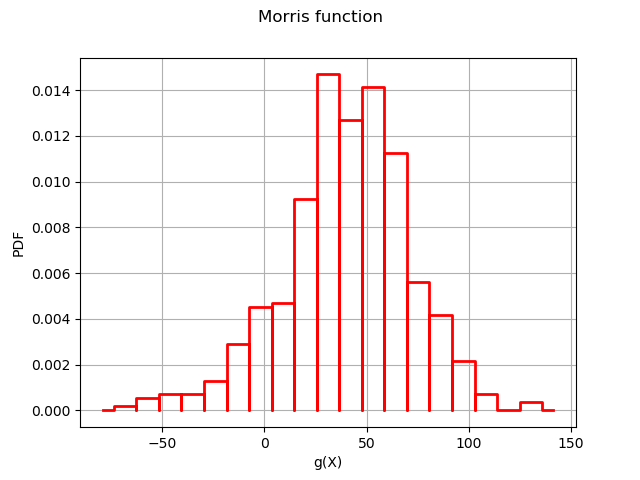

In [10]:
graph = ot.VisualTest_DrawHistogram(sampleY)
graph.setLegends([""])
graph.setTitle("Morris function")
graph.setXTitle("g(X)")
graph.setYTitle("PDF")
graph